In [1]:
import os
import sys
import numpy as np
import pandas as pd

import joblib
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from rdkit import Chem
from rdkit.Chem.Draw import MolToImage
from rdkit.Chem.Draw.MolDrawing import Font

import deepchem as dc
from deepchem.feat.mol_graphs import WeaveMol
from deepchem.feat import WeaveFeaturizer
from deepchem.data.datasets import NumpyDataset

%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt
font = {
    'font.family': 'sans-serif',
    'font.sans-serif': 'Arial',
    'font.size': 18,
}
plt.rcParams.update(font)

sys.path.append("../data/")
from classes import families, validate_family, add_tags

# Preliminaries

## Load Dataset

In [3]:
model_dir = '../results/mpnn03-repeat028'

In [4]:
raw_training_data = joblib.load(model_dir + '/training.joblib')
raw_testing_data = joblib.load(model_dir + '/testing.joblib')
transformers = joblib.load(model_dir + '/transformers.joblib')

transformed_data = []
for dataset in [raw_training_data, raw_testing_data]:
    for transformer in transformers:
          transformed_data.append(transformer.transform(dataset))
training_data, testing_data = tuple(transformed_data)

## Load Model

In [5]:
model = dc.models.MPNNTensorGraph(n_tasks=1)

In [6]:
with open(model_dir+'/model.pickle', 'rb') as fout:
    model = pickle.load(fout)
model.built = False
model.model_dir = model_dir
model.restore()

/localdata0/Code/Python/anaconda3/envs/deepchem_py3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Restoring parameters from ../results/mpnn03-repeat028/model-500


## Validate Load

In [7]:
training_predictions = model.predict(training_data)

In [8]:
testing_predictions = model.predict(testing_data)

In [9]:
untransformed_data = []
for dataset in [training_predictions, testing_predictions]:

          untransformed_data.append(transformer.untransform(dataset))
raw_training_predictions, raw_testing_predictions = tuple(untransformed_data)

Text(0.5,1,'Training Dataset (n=318, RMSE=1.33 min)')

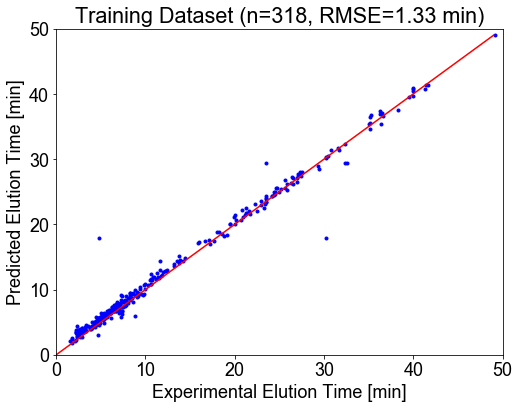

In [10]:
plt.rcParams.update(font)
y_expt = raw_training_data.y
y_expt = y_expt.flatten()
y_pred = raw_training_predictions
y_pred = y_pred.flatten()
fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.add_subplot(111)
ax1.plot(y_expt, y_pred, 'b.')
ax1.plot(np.arange(0, max(y_expt)), np.arange(0, max(y_expt)), 'r-')
ax1.set_xlabel("Experimental Elution Time [min]")
ax1.set_ylabel("Predicted Elution Time [min]")
ax1.set_xlim([0, 50])
ax1.set_ylim([0, 50])
ax1.set_title("Training Dataset (n={:d}, RMSE={:.2f} min)".format(
    len(y_expt), 
    np.sqrt(mean_squared_error(y_expt, y_pred))))
#fig1.savefig(model.model_dir + "/Training_Performance.png")

In [11]:
bad_molecules = raw_training_data.ids[(np.abs(y_pred - y_expt)) > 2]

print("On Training Data:")
print(f"Percentage of molecules with error > 2 minutes: {len(bad_molecules)*100/len(y_expt):.1f}%")
print(f"Number of molecules with error > 2 minutes: {len(bad_molecules):d}")

On Training Data:
Percentage of molecules with error > 2 minutes: 2.5%
Number of molecules with error > 2 minutes: 8


Text(0.5,1,'Test Dataset (n=80, RMSE=4.04 min)')

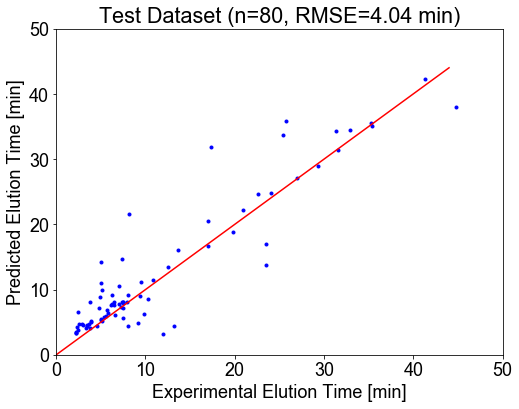

In [12]:
y_expt = raw_testing_data.y
y_expt = y_expt.flatten()
y_pred = raw_testing_predictions
y_pred = y_pred.flatten()
fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.add_subplot(111)
ax1.plot(y_expt, y_pred, 'b.')
ax1.plot(np.arange(0, max(y_expt)), np.arange(0, max(y_expt)), 'r-')
ax1.set_xlabel("Experimental Elution Time [min]")
ax1.set_ylabel("Predicted Elution Time [min]")
ax1.set_xlim([0, 50])
ax1.set_ylim([0, 50])
ax1.set_title("Test Dataset (n={:d}, RMSE={:.2f} min)".format(
    len(y_expt), 
    np.sqrt(mean_squared_error(y_expt, y_pred))))
#fig1.savefig(model.model_dir + "/Test_Performance.png")

In [13]:
cutoff = 2
bad_molecules = raw_testing_data.ids[(np.abs(y_pred - y_expt)) > cutoff]

print("On Test Data:")
print(f"Percentage of molecules with error > {cutoff:d} minutes: {len(bad_molecules)*100/len(y_expt):.1f}%")
print(f"Number of molecules with error > {cutoff:d} minutes: {len(bad_molecules):d}")

On Test Data:
Percentage of molecules with error > 2 minutes: 33.8%
Number of molecules with error > 2 minutes: 27


In [14]:
cutoff = 2
bad_molecules = raw_testing_data.ids[(np.abs(y_pred - y_expt)) > cutoff]

print("On Test Data:")
print(f"Percentage of molecules with error > {cutoff:d} minutes: {len(bad_molecules)*100/len(y_expt):.1f}%")
print(f"Number of molecules with error > {cutoff:d} minutes: {len(bad_molecules):d}")

On Test Data:
Percentage of molecules with error > 2 minutes: 33.8%
Number of molecules with error > 2 minutes: 27


# Model Elucidation

In [15]:
raw_dataset = pd.read_csv('../data/combined_time.csv',
                          usecols=['CNAME', 'smiles', 'neg RT (min)'])
raw_dataset.head()

,CNAME,smiles,neg RT (min)
0,SELENOMETHIONINE,C[Se]CCC(C(=O)O)N,6.25
1,L-LYSINE,C(CCCN)C(C(=O)O)N,22.99
2,L-ORNITHINE,C(CCN)C(C(=O)O)N,23.52
3,DL-5-HYDROXYLYSINE,C(CCC(CN)O)(C(=O)O)N,23.54
4,NORADRENALINE,C(CN)(c1cc(c(cc1)O)O)O,24.13


## Identify Key Features

In [17]:
contrib_data = pickle.load(open(model_dir + '/contrib_data.p', 'rb'))

In [21]:
idx = 0
mol, error, prediction, contributions = contrib_data[idx]

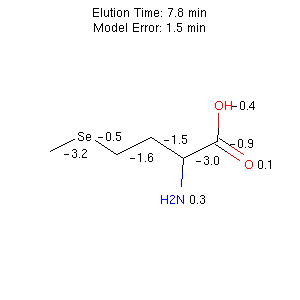

In [23]:
img, canvas, drawer = MolToImage(mol, returnCanvas=True)
font=Font(face='sans',size=12)
assert len(contributions) == mol.GetNumAtoms()
for i in range(mol.GetNumAtoms()):
    position = [drawer.atomPs[drawer.activeMol][i][0], drawer.atomPs[drawer.activeMol][i][1], 1.0]
    canvas.addCanvasText("{:.1f}".format(contributions[i]), position, font)
    canvas.addCanvasText("Elution Time: {:.1f} min".format(prediction), 
                         [canvas.size[0]/2.0, 10, 0],
                         font)
    canvas.addCanvasText("Model Error: {:.1f} min".format(error), 
                         [canvas.size[0]/2.0, 25, 0],
                         font)
    canvas.flush()
img